# Info

This notebook created to analyze FeTAv2.1 dataset.

In [1]:
import os

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

from modules.Utils import get_file_names

## Metadata Analysis

In [128]:
meta_data = pd.read_csv('data/feta_processed/participants.tsv', sep='\t')
mri_paths = get_file_names('data\\feta_processed\\')

assert len(meta_data) == len(mri_paths), 'Missing report or MRI data.'
print('Total number of subjects: {}'.format(len(meta_data)))

Total number of subjects: 80


In [3]:
meta_data.sample(5)

,participant_id,Pathology,Gestational age
65,sub-066,Pathological,21.8
21,sub-022,Pathological,20.0
38,sub-039,Neurotypical,24.3
29,sub-030,Neurotypical,33.4
25,sub-026,Neurotypical,27.8


In [4]:
meta_data.groupby('Pathology').count()['participant_id'].to_frame()

,participant_id
Pathology,
Neurotypical,33
Pathological,47


In [5]:
print('The youngest GA: {}'.format(meta_data['Gestational age'].min()))
print('The oldest GA: {}'.format(meta_data['Gestational age'].max()))

The youngest GA: 20.0
The oldest GA: 34.8


In [6]:
meta_data.groupby(pd.cut(meta_data['Gestational age'], 5)).count()['participant_id'].to_frame()

,participant_id
Gestational age,
"(19.985, 22.96]",12
"(22.96, 25.92]",19
"(25.92, 28.88]",25
"(28.88, 31.84]",15
"(31.84, 34.8]",9


## MRI Analysis

In [7]:
sample_mial = nib.load(mri_paths['sub-015'][0]).get_fdata()
sample_mial_mask = nib.load(mri_paths['sub-015'][1]).get_fdata()

sample_irtk = nib.load(mri_paths['sub-065'][0]).get_fdata()
sample_irtk_mask = nib.load(mri_paths['sub-065'][1]).get_fdata()

In [8]:
print('Shape of the sample that was reconstructed with mial: {}'.format(sample_mial.shape))
print('Shape of the sample mask that was reconstructed with mial: {}\n'.format(sample_mial_mask.shape))
print('Shape of the sample that was reconstructed with irtk: {}'.format(sample_irtk.shape))
print('Shape of the sample mask that was reconstructed with irtk: {}'.format(sample_irtk_mask.shape))

Shape of the sample that was reconstructed with mial: (128, 144, 145)
Shape of the sample mask that was reconstructed with mial: (128, 144, 145)

Shape of the sample that was reconstructed with irtk: (133, 159, 139)
Shape of the sample mask that was reconstructed with irtk: (133, 159, 139)


In [45]:
def plot_sample(sample, title=None):
    axial = sample[:, :, int(sample.shape[2]/2)]
    coronal = sample[:, int(sample.shape[1]/2), :]
    sagittal = sample[int(sample.shape[0]/2), :, :]
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    plt.suptitle(title, y=0.65, fontsize=15)
    
    axes[0].imshow(np.rot90(axial, 3), cmap='gray')
    axes[0].set_xlabel('Axial')
    axes[1].imshow(np.rot90(coronal, 1), cmap='gray')
    axes[1].set_xlabel('Coronal')
    axes[2].imshow(np.rot90(sagittal, 1), cmap='gray')
    axes[2].set_xlabel('Sagittal')
    
    plt.show()

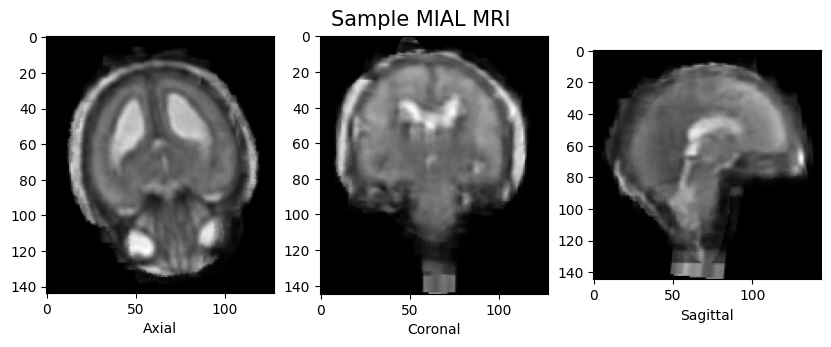

In [46]:
plot_sample(sample_mial, 'Sample MIAL MRI')

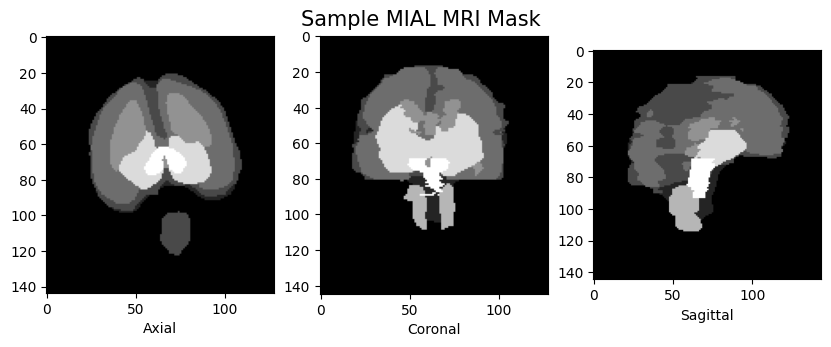

In [47]:
plot_sample(sample_mial_mask, 'Sample MIAL MRI Mask')

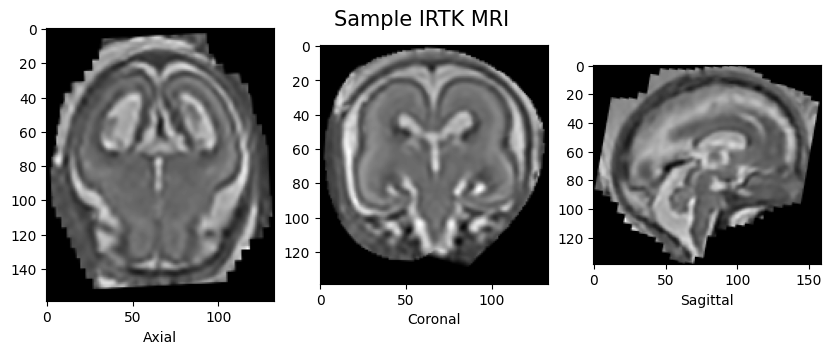

In [48]:
plot_sample(sample_irtk, 'Sample IRTK MRI')

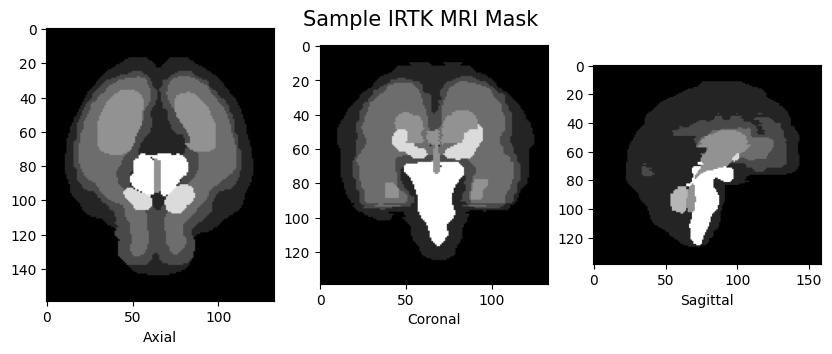

In [49]:
plot_sample(sample_irtk_mask, 'Sample IRTK MRI Mask')

In [51]:
# Pixel values. That indicates how many category/label exist in the mask.
print(np.unique(sample_mial_mask))

[0. 1. 2. 3. 4. 5. 6. 7.]


In [134]:
mial_pixels = []
irtk_pixels = []

for i, (sub, paths) in enumerate(mri_paths.items()):
    mri = nib.load(paths[0]).get_fdata()    
    if i < 40:
        mial_pixels.extend(mri.flatten())
    else:
        irtk_pixels.extend(mri.flatten())
        
all_pixels = mial_pixels + irtk_pixels

In [139]:
min_value_pixel = min(all_pixels)
max_value_pixel = max(all_pixels)

print('Total number of pixels: {}'.format(len(all_pixels)))
print('Min value of pixels: {}'.format(min_value_pixel))
print('Max value of pixels: {}'.format(max_value_pixel))

Total number of pixels: 480096228
Min value of pixels: 0.0
Max value of pixels: 1833.0


In [143]:
mean_mial = np.mean(mial_pixels)
std_mial = np.std(mial_pixels)

mean_irtk = np.mean(irtk_pixels)
std_irtk = np.std(irtk_pixels)

mean_all = np.mean(all_pixels)
std_all = np.std(all_pixels)

print('Mean of MIAL: {}'.format(round(mean_mial, 4)))
print('Standard Deviation of MIAL: {}'.format(round(std_mial, 4)))
print('Mean of IRTK: {}'.format(round(mean_irtk, 4)))
print('Standard Deviation of IRTK: {}'.format(round(std_irtk, 4)))
print('Mean of all: {}'.format(round(mean_all, 4)))
print('Standard Deviation of all: {}'.format(round(std_all, 4)))

Mean of MIAL: 181.3585
Standard Deviation of MIAL: 278.3086
Mean of IRTK: 74.7632
Standard Deviation of IRTK: 94.8568
Mean of all: 126.9263
Standard Deviation of all: 212.9259


In [123]:
tissue_classes = ["Background", "eCSF", "Gray Matter", "White Matter", "Ventricles", 
                  "Cerrebilium", "Deep Gray Matter", "Brain Stem"]

def plot_mask_hist(mask, title):    
    fig, axes = plt.subplots()
    fig.suptitle(title)
    axes.hist(mask.flatten(), range=(1, np.max(mask)))
    axes.set_xticks(range(1, len(tissue_classes)))
    axes.set_xticklabels(tissue_classes[1:], rotation=45, rotation_mode="anchor", ha="right")
    plt.show()

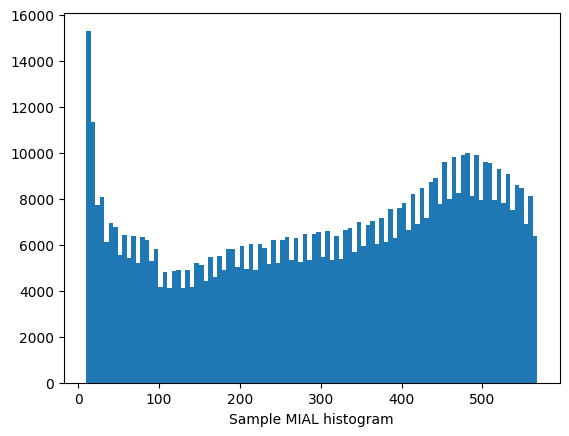

In [69]:
plt.hist(sample_mial.flatten(), 100, range=(10, np.max(sample_irtk)))
plt.xlabel('Sample MIAL histogram')
plt.show()

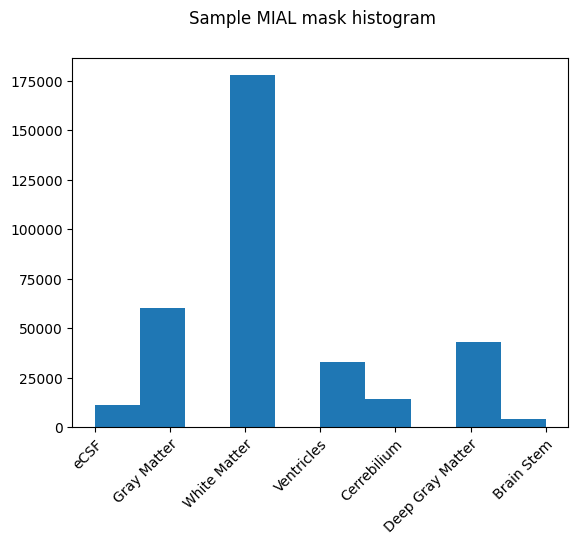

In [124]:
plot_mask_hist(sample_mial_mask, 'Sample MIAL mask histogram')

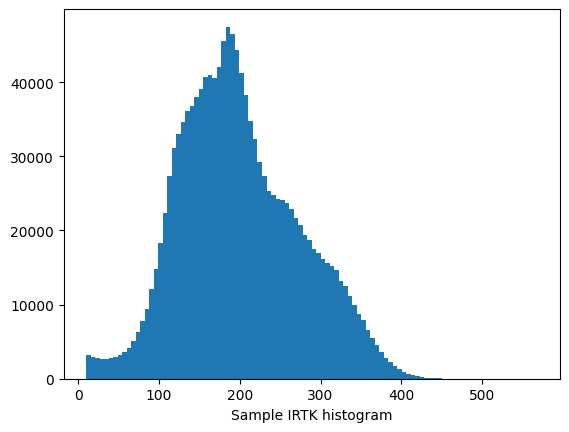

In [67]:
plt.hist(sample_irtk.flatten(), 100, range=(10, np.max(sample_irtk)))
plt.xlabel('Sample IRTK histogram')
plt.show()

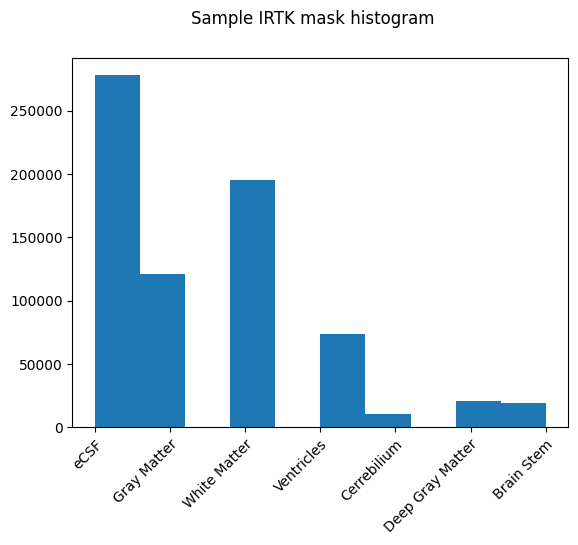

In [125]:
plot_mask_hist(sample_irtk_mask, 'Sample IRTK mask histogram')

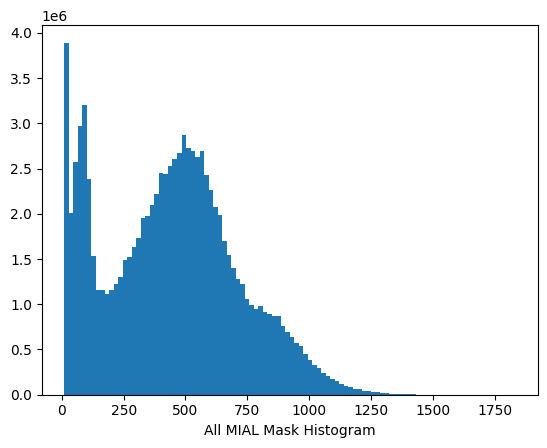

In [126]:
plt.hist(mial_pixels, 100, range=(10, np.max(mial_pixels)))
plt.xlabel('All MIAL Mask Histogram')
plt.show()

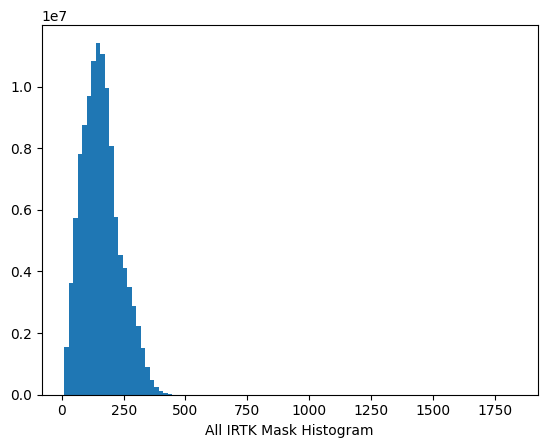

In [127]:
plt.hist(irtk_pixels, 100, range=(10, np.max(mial_pixels)))
plt.xlabel('All IRTK Mask Histogram')
plt.show()